### 1. Описание набора данных

Набор данных ```German Credit``` содержит сведения о людях, которые берут кредит в банке, где каждый человек классифицируется как хороший или плохой заемщик (кредитный риск).

### 2. Импорт библиотек

In [34]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import scipy.stats as ss
import seaborn as sns
import urllib.request
import warnings

from sklearn.metrics import (
  accuracy_score, average_precision_score,
  confusion_matrix, f1_score,
  recall_score, roc_auc_score
)
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.svm import SVC

In [35]:
warnings.filterwarnings('ignore')
logging.getLogger('matplotlib').setLevel(logging.ERROR)

### 3. Определение функций

In [36]:
def cramers_v(x, y):
  confusion_matrix = pd.crosstab(x, y)
  chi2 = ss.chi2_contingency(confusion_matrix)[0]
  n = confusion_matrix.sum().sum()
  phi2 = chi2 / n
  r, k = confusion_matrix.shape
  phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
  rcorr = r - ((r - 1) ** 2) / (n - 1)
  kcorr = k - ((k - 1) ** 2) / (n - 1)
  return np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))

In [37]:
def cramers_col(X, columns, column_name):
  col = pd.Series(np.empty(X[columns].columns.shape), index=X[columns].columns, name=column_name)
  for row in X[columns]:
    cram = cramers_v(X[columns][column_name], X[columns][row])
    col[row] = round(cram, 2)
  return col

### 4. Создание каталога и скачивание данных

In [38]:
if not os.path.exists('data'):
  os.makedirs('data')

if not os.path.exists('data/german_credit.csv'):
  urllib.request.urlretrieve('https://raw.githubusercontent.com/Losyash/mbml_II_hw/refs/heads/main/lab1/data/german_credit.csv', 'data/german_credit.csv')

### 5. Загрузка набора данных из файла

In [39]:
df = pd.read_csv('data/german_credit.csv')
df.head()

,Creditability,Account Balance,Duration of Credit (month),Payment Status of Previous Credit,Purpose,Credit Amount,Value Savings/Stocks,Length of current employment,Instalment per cent,Sex & Marital Status,...,Duration in Current address,Most valuable available asset,Age (years),Concurrent Credits,Type of apartment,No of Credits at this Bank,Occupation,No of dependents,Telephone,Foreign Worker
0,1,1,18,4,2,1049,1,2,4,2,...,4,2,21,3,1,1,3,1,1,1
1,1,1,9,4,0,2799,1,3,2,3,...,2,1,36,3,1,2,3,2,1,1
2,1,2,12,2,9,841,2,4,2,2,...,4,1,23,3,1,1,2,1,1,1
3,1,1,12,4,0,2122,1,3,3,3,...,2,1,39,3,1,2,2,2,1,2
4,1,1,12,4,0,2171,1,3,4,3,...,4,2,38,1,2,2,2,1,1,2


### 6. Предварительный анализ и предобработка данных

#### 6.1. Вывод информации и структуре данных

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column                             Non-Null Count  Dtype
---  ------                             --------------  -----
 0   Creditability                      1000 non-null   int64
 1   Account Balance                    1000 non-null   int64
 2   Duration of Credit (month)         1000 non-null   int64
 3   Payment Status of Previous Credit  1000 non-null   int64
 4   Purpose                            1000 non-null   int64
 5   Credit Amount                      1000 non-null   int64
 6   Value Savings/Stocks               1000 non-null   int64
 7   Length of current employment       1000 non-null   int64
 8   Instalment per cent                1000 non-null   int64
 9   Sex & Marital Status               1000 non-null   int64
 10  Guarantors                         1000 non-null   int64
 11  Duration in Current address        1000 non-null   int64
 12  Most valuable availab

#### 6.2. Вывод количества значений целевой переменной в каждом классе

In [41]:
df['Creditability'].value_counts()

Creditability
1    700
0    300
Name: count, dtype: int64

#### 6.3. Разделение набора данных на набор с признаками и целевой переменной

In [42]:
X, y = df.drop('Creditability', axis=1), df['Creditability']

#### 6.4. Вывод гистограмм распределения признаков

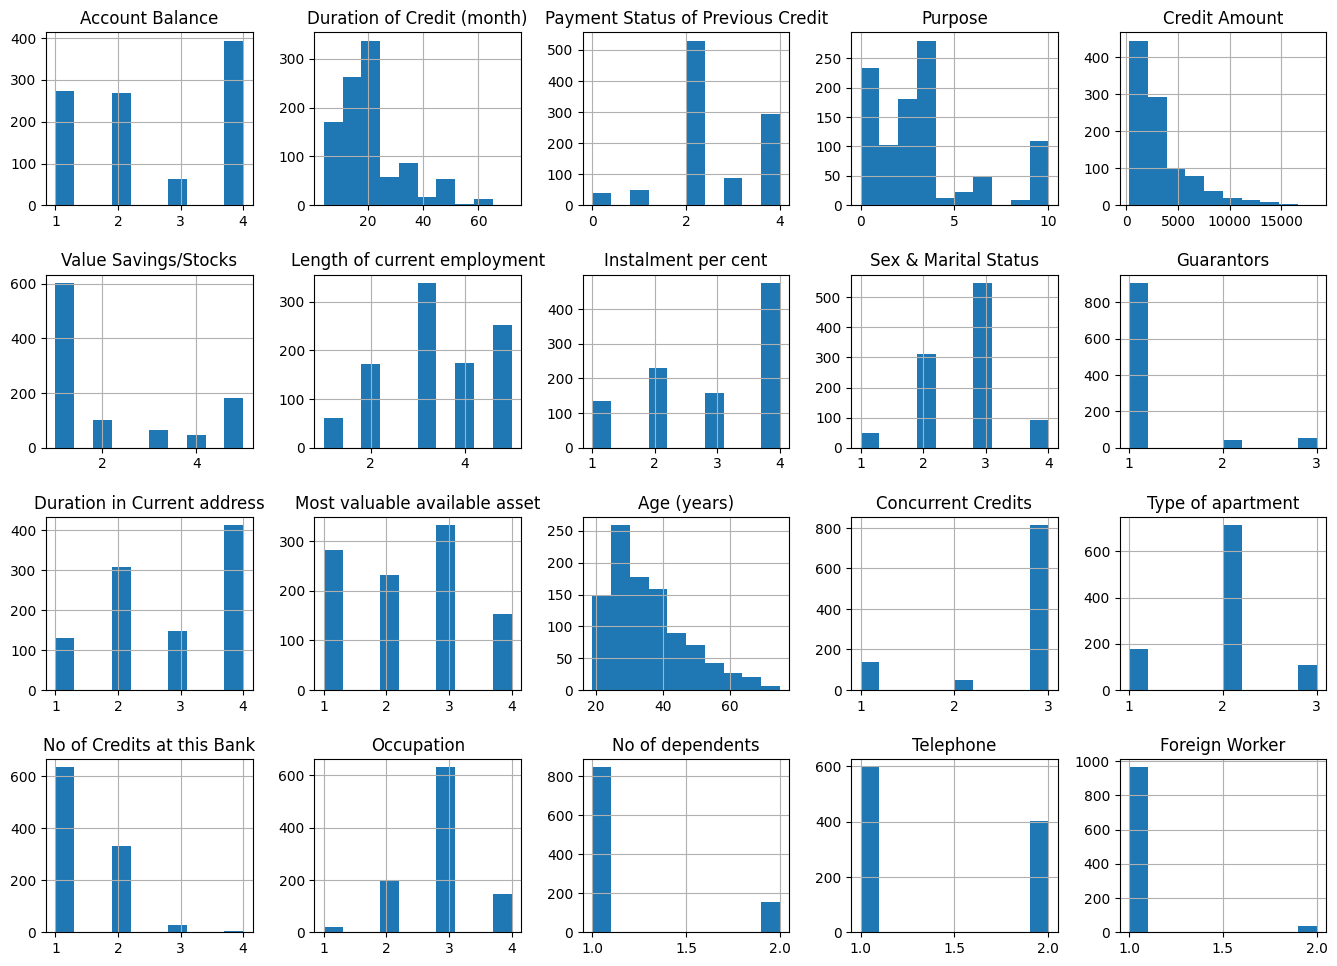

In [43]:
rows_number = 4
columns_number = 5

fig, axes = plt.subplots(nrows=rows_number, ncols=columns_number, figsize=(16, 10))

for i, column in enumerate(X.columns):
  row = i // columns_number
  col = i % columns_number

  X[column].hist(ax=axes[row, col], bins=10)
  axes[row, col].set_title(column)

plt.subplots_adjust(left=0, right=0.8, bottom=0, top=0.9, wspace=0.3, hspace=0.4)
plt.show()

#### 6.4. Выделение категориальных и числовых столбцов

In [44]:
categorical_columns = [
  'Account Balance',
  'Concurrent Credits',
  'Duration in Current address',
  'Foreign Worker',
  'Guarantors',
  'Instalment per cent',
  'Length of current employment',
  'Most valuable available asset',
  'No of Credits at this Bank',
  'No of dependents',
  'Occupation',
  'Payment Status of Previous Credit',
  'Purpose',
  'Sex & Marital Status',
  'Telephone',
  'Type of apartment',
  'Value Savings/Stocks'
]

numeric_columns = [
  'Age (years)',
  'Credit Amount',
  'Duration of Credit (month)'
]

#### 6.5. Масштабирование числовых признаков

In [45]:
scaler = StandardScaler()

data_scaled = scaler.fit_transform(X[numeric_columns])
df_scaled = pd.DataFrame(data_scaled, columns=numeric_columns)

df_processed = pd.concat([X.drop(columns=numeric_columns), df_scaled], axis=1)

#### 6.6. Отображение числовых данных в гауссово распределение

In [46]:
transformer = PowerTransformer(method='yeo-johnson')

data_transformed = transformer.fit_transform(df_scaled)
df_transformed = pd.DataFrame(data_transformed, columns=df_scaled.columns)

df_processed = pd.concat([X.drop(columns=numeric_columns), df_transformed], axis=1)

### 7. Формулировка начальных гипотез


#### 7.1. Расчет коэффициента корреляции Пирсона для числовых признаков

In [47]:
corr_pirson = df_processed[numeric_columns].corrwith(y)
corr_pirson

Age (years)                   0.109702
Credit Amount                -0.103795
Duration of Credit (month)   -0.213698
dtype: float64

#### 7.2. Рассчет V-коэффициента корреляции Крамера (Cramer's V) для измерения связи между категориальными переменными

In [48]:
for column in categorical_columns:
  corr_cramers = cramers_v(df_processed[column], y)
  print(f'{column:<35} {corr_cramers}')

Account Balance                     0.3476189010590424
Concurrent Credits                  0.10415394681626367
Duration in Current address         0.0
Foreign Worker                      0.06946513621535383
Guarantors                          0.06817636837744626
Instalment per cent                 0.049762112985545254
Length of current employment        0.11991106245316734
Most valuable available asset       0.14400453584964393
No of Credits at this Bank          0.0
No of dependents                    0.0
Occupation                          0.0
Payment Status of Previous Credit   0.24030230119486998
Purpose                             0.1561148105809381
Sex & Marital Status                0.08129468862215453
Telephone                           0.013104557655738326
Type of apartment                   0.12918478550166898
Value Savings/Stocks                0.1792402952214944


In [49]:
df_cramers = X[categorical_columns].apply(lambda column: cramers_col(X, categorical_columns, column.name))

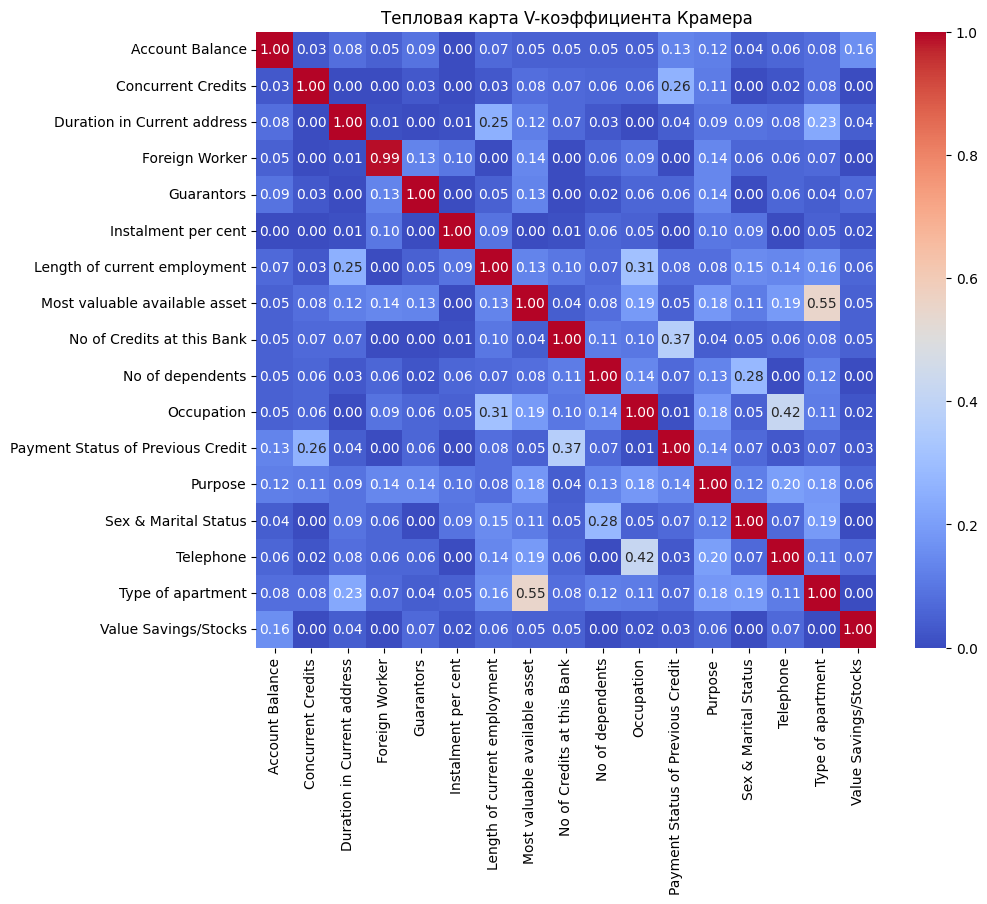

In [50]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_cramers, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Тепловая карта V-коэффициента Крамера')
plt.show()

### 8. Выводы по результатам анализа данных

#### 8.1. Анализ целевой переменной

- набор данных несбалансирован, что может привести к снижению точности модели, неправильным метрикам, ошибкам в интерпретации результатов.

#### 8.2. Анализ коэффициента корреляции Пирсона

- корреляции между признаками не являются высокими, однако логично отражают влияние признаков на целевую переменную;
- чем меньше срок и величина кредита, тем вероятней одобрят кредит;
- чем старше заемщик, тем менее вероятно одобрят кредит.

#### 8.3. Анализ значимости признаков для решения задачи классификации

- наиболее полезными признаками являются `Duration of Credit (month)`, `Account Balance`, `Payment Status of Previous Credit`;
- наименее полезными могут быть следующие признаки ```Instalment per cent```, ```Sex & Marital Status```, ```Guarantors```,  ```Duration in Current address```, ```No of Credits at this Bank```, ```Occupation```, ```No of dependents```, ```Telephone```, ```Foreign Worker```;
- `Most valuable available asset` достаточно сильно коррелирует с `Type of apartment`;
- `Payment Status of Previous Credit` достаточно сильно коррелирует с  `No of Credits at this Bank`;
- `Occupation` достаточно сильно коррелирует с  `Telephone`.

### 9. Разбиение данных на тренировочную и тестовую выборку

In [51]:
X_train, X_test, y_train, y_test = train_test_split(df_processed, y, test_size=0.25, random_state=42)

### 10. Обучение базовой модели на основе  метода опорных векторов

#### 10.1. Создание и обучение модели

In [52]:
svm_classifier = SVC(probability=True, random_state=42)
svm_classifier.fit(X_train[numeric_columns], y_train);

#### 10.2. Предсказание на тренировочной и тестовой выборках

In [53]:
y_train_predict = svm_classifier.predict(X_train[numeric_columns])
y_test_predict = svm_classifier.predict(X_test[numeric_columns])

#### 10.3. Анализ метрик на тренировочных и тестовых данных

In [54]:
accuracy_train = accuracy_score(y_train, y_train_predict)
accuracy_test = accuracy_score(y_test, y_test_predict)

recall_train = recall_score(y_train, y_train_predict)
recall_test = recall_score(y_test, y_test_predict)

f1_train = f1_score(y_train, y_train_predict)
f1_test = f1_score(y_test, y_test_predict)

roc_auc_train = roc_auc_score(y_train, y_train_predict)
roc_auc_test = roc_auc_score(y_test, y_test_predict)

y_score_train = svm_classifier.predict_proba(X_train[numeric_columns])[:, 1]
pr_auc_train = average_precision_score(y_train, y_score_train)

y_score_test = svm_classifier.predict_proba(X_test[numeric_columns])[:, 1]
pr_auc_test = average_precision_score(y_test, y_score_test)

print(
  f'Точность на тренировочных данных: {accuracy_train}',
  f'Точность на тестовых данных:      {accuracy_test}',
  '----------------------------------------------------',
  f'Полнота на тренировочных данных:  {recall_train}',
  f'Полнота на тестовых данных:       {recall_test}',
  '----------------------------------------------------',
  f"F-мера на тренировочных данных:   {f1_train}",
  f"F-мера на тестовых данных:        {f1_test}",
  '----------------------------------------------------',
  f'ROC AUC на тренировочных данных:  {roc_auc_train}',
  f'ROC AUC на тестовых данных:       {roc_auc_test}',
  '----------------------------------------------------',
  f'PR AUC на тренировочных данных:   {pr_auc_train}',
  f'PR AUC на тестовых данных:        {pr_auc_test}',
  sep='\n'
)

Точность на тренировочных данных: 0.7226666666666667
Точность на тестовых данных:      0.716
----------------------------------------------------
Полнота на тренировочных данных:  0.9866666666666667
Полнота на тестовых данных:       0.9828571428571429
----------------------------------------------------
F-мера на тренировочных данных:   0.8327974276527331
F-мера на тестовых данных:        0.8289156626506025
----------------------------------------------------
ROC AUC на тренировочных данных:  0.5466666666666666
ROC AUC на тестовых данных:       0.5380952380952382
----------------------------------------------------
PR AUC на тренировочных данных:   0.8317768122324374
PR AUC на тестовых данных:        0.7623114661502951


#### 10.4. Анализ матрицы ошибок на тестовых данных

In [55]:
error_matrix = confusion_matrix(y_test, y_test_predict)
error_matrix

array([[  7,  68],
       [  3, 172]])

In [56]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()

print(
  f'Истинно отрицательные (true negatives, TN): {tn}',
  '-----------------------------------------------',
  f'Ложно положительные (false positives, FP):  {fp}',
  '-----------------------------------------------',
  f'Ложно отрицательные (false negatives, FN):  {fn}',
  '-----------------------------------------------',
  f'Истинно положительные (true positives, TP): {tp}',
  sep='\n'
)

Истинно отрицательные (true negatives, TN): 7
-----------------------------------------------
Ложно положительные (false positives, FP):  68
-----------------------------------------------
Ложно отрицательные (false negatives, FN):  3
-----------------------------------------------
Истинно положительные (true positives, TP): 172


#### 10.5. Выводы по результатам обучения базовой модели

- ```точность (accuracy)```, равная```0,716```, показывает, что модель правильно классифицировала 71,6% всех тестовых примеров, что является неплохим результатом; однако надо учитывать, что в силу несбалансированости классов модель может иметь высокую точность, но не справляться с классификацией отдельных классов;
- ```полнота (recall)```, равная ```0,982``` показывает, что модель смогла идентифицировать 98,2% положительных примеров, что также является хорошим результатом для оценки количества пропущенных положительных случаев;
- ```F-мера (F1 Score)```, равная ```0,828``` показывает, что общую эффективность модели в оценке правильно классифицированных примеров и в обнаружении всех положительных случаев;
- ```ROC AUC```, равная ```0,538``` показывает средний уровень способности модели различать положительные и отрицательные классы;
- ```PR AUC```, равная ```0,762``` показывает, что модель хорошо справляется с балансом между точностью и полнотой, но, как и ROC AUC, может указывать на потенциальные проблемы с балансом между классами.

По вышеперечисленным метрикам можно осделать вывод, что модель хорошо работает с положительными случаями, но может пропускать большое число отрицательных.

### 11. Обучение модели с категориальными признаками

#### 11.1. Обучение модели

In [57]:
svm_classifier.fit(X_train, y_train);

#### 11.2. Предсказание на тренировочных и тестовых данных

In [58]:
y_train_predict = svm_classifier.predict(X_train)
y_test_predict = svm_classifier.predict(X_test)

#### 11.3. Анализ метрик на тренировочных и тестовых данных

In [59]:
accuracy_train = accuracy_score(y_train, y_train_predict)
accuracy_test = accuracy_score(y_test, y_test_predict)

recall_train = recall_score(y_train, y_train_predict)
recall_test = recall_score(y_test, y_test_predict)

f1_train = f1_score(y_train, y_train_predict)
f1_test = f1_score(y_test, y_test_predict)

roc_auc_train = roc_auc_score(y_train, y_train_predict)
roc_auc_test = roc_auc_score(y_test, y_test_predict)

y_score_train = svm_classifier.predict_proba(X_train)[:, 1]
pr_auc_train = average_precision_score(y_train, y_score_train)

y_score_test = svm_classifier.predict_proba(X_test)[:, 1]
pr_auc_test = average_precision_score(y_test, y_score_test)

print(
  f'Точность на тренировочных данных: {accuracy_train}',
  f'Точность на тестовых данных:      {accuracy_test}',
  '----------------------------------------------------',
  f'Полнота на тренировочных данных:  {recall_train}',
  f'Полнота на тестовых данных:       {recall_test}',
  '----------------------------------------------------',
  f"F-мера на тренировочных данных:   {f1_train}",
  f"F-мера на тестовых данных:        {f1_test}",
  '----------------------------------------------------',
  f'ROC AUC на тренировочных данных:  {roc_auc_train}',
  f'ROC AUC на тестовых данных:       {roc_auc_test}',
  '----------------------------------------------------',
  f'PR AUC на тренировочных данных:   {pr_auc_train}',
  f'PR AUC на тестовых данных:        {pr_auc_test}',
  sep='\n'
)

Точность на тренировочных данных: 0.7986666666666666
Точность на тестовых данных:      0.772
----------------------------------------------------
Полнота на тренировочных данных:  0.9504761904761905
Полнота на тестовых данных:       0.9428571428571428
----------------------------------------------------
F-мера на тренировочных данных:   0.8685813751087903
F-мера на тестовых данных:        0.8527131782945736
----------------------------------------------------
ROC AUC на тренировочных данных:  0.6974603174603174
ROC AUC на тестовых данных:       0.6580952380952381
----------------------------------------------------
PR AUC на тренировочных данных:   0.9197287544028067
PR AUC на тестовых данных:        0.9018549693739871


#### 11.4. Анализ матрицы ошибок на тестовых данных

In [60]:
error_matrix = confusion_matrix(y_test, y_test_predict)
error_matrix

array([[ 28,  47],
       [ 10, 165]])

In [61]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()

print(
  f'Истинно отрицательные (true negatives, TN): {tn}',
  '-----------------------------------------------',
  f'Ложно положительные (false positives, FP):  {fp}',
  '-----------------------------------------------',
  f'Ложно отрицательные (false negatives, FN):  {fn}',
  '-----------------------------------------------',
  f'Истинно положительные (true positives, TP): {tp}',
  sep='\n'
)

Истинно отрицательные (true negatives, TN): 28
-----------------------------------------------
Ложно положительные (false positives, FP):  47
-----------------------------------------------
Ложно отрицательные (false negatives, FN):  10
-----------------------------------------------
Истинно положительные (true positives, TP): 165


#### 11.5. Выводы по результатам обучения модели с категориальными признаками

- ```точность (accuracy)``` увеличилась с ```0,716``` до ```0,772```, что указывает на улучшение обобщающей способности модели;
- ```полнота (recall)``` снизилась с ```0,982``` до ```0,942```, что означает увеличение количества ложно отрицательных результатов;
- ```F-мера (F1 Score)``` незначительно увеличилась с ```0,828``` до ```0,852```, что сохранился баланс между точностью и полнотой;
- ```ROC AUC``` увеличилась с ```0,538``` до ```0,658```, что показывает улучшение способности модели различать положительные и отрицательные случаи;
- ```PR AUC``` увеличилась с ```0,762``` до ```0,901```, что показывает улучшение способности модели различать положительные и отрицательные случаи.

По вышеперечисленным метрикам можно осделать вывод, что модель стала лучше предсказывать отрицательные случаи, при это ухудшилась ее способность предсказывать положительные случаи.

### 12. Обучение модели c модель с оптимизированными гиперпараметрами

#### 12.1. Создание и обучение модели

In [62]:
param_grid = {
  'C': [ 0.1, 1, 10, 100 ],
  'gamma': [ 0.001, 0.01, 0.1, 1 ],
  'kernel': [ 'linear', 'rbf' ]
}

grid_search = GridSearchCV(svm_classifier, param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Лучшие гиперпараметры: ", grid_search.best_params_)

Лучшие гиперпараметры:  {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}


#### 12.2. Предсказание на тренировочных и тестовых данных

In [63]:
y_train_predict = grid_search.predict(X_train)
y_test_predict = grid_search.predict(X_test)

#### 12.3. Анализ метрик на тренировочных и тестовых данных

In [64]:
accuracy_train = accuracy_score(y_train, y_train_predict)
accuracy_test = accuracy_score(y_test, y_test_predict)

recall_train = recall_score(y_train, y_train_predict)
recall_test = recall_score(y_test, y_test_predict)

f1_train = f1_score(y_train, y_train_predict)
f1_test = f1_score(y_test, y_test_predict)

roc_auc_train = roc_auc_score(y_train, y_train_predict)
roc_auc_test = roc_auc_score(y_test, y_test_predict)

y_score_train = grid_search.predict_proba(X_train)[:, 1]
pr_auc_train = average_precision_score(y_train, y_score_train)

y_score_test = grid_search.predict_proba(X_test)[:, 1]
pr_auc_test = average_precision_score(y_test, y_score_test)

print(
  f'Точность на тренировочных данных: {accuracy_train}',
  f'Точность на тестовых данных:      {accuracy_test}',
  '----------------------------------------------------',
  f'Полнота на тренировочных данных:  {recall_train}',
  f'Полнота на тестовых данных:       {recall_test}',
  '----------------------------------------------------',
  f"F-мера на тренировочных данных:   {f1_train}",
  f"F-мера на тестовых данных:        {f1_test}",
  '----------------------------------------------------',
  f'ROC AUC на тренировочных данных:  {roc_auc_train}',
  f'ROC AUC на тестовых данных:       {roc_auc_test}',
  '----------------------------------------------------',
  f'PR AUC на тренировочных данных:   {pr_auc_train}',
  f'PR AUC на тестовых данных:        {pr_auc_test}',
  sep='\n'
)

Точность на тренировочных данных: 0.768
Точность на тестовых данных:      0.764
----------------------------------------------------
Полнота на тренировочных данных:  0.9142857142857143
Полнота на тестовых данных:       0.9085714285714286
----------------------------------------------------
F-мера на тренировочных данных:   0.8465608465608465
F-мера на тестовых данных:        0.843501326259947
----------------------------------------------------
ROC AUC на тренировочных данных:  0.6704761904761904
ROC AUC на тестовых данных:       0.6676190476190476
----------------------------------------------------
PR AUC на тренировочных данных:   0.8918403845616123
PR AUC на тестовых данных:        0.8998855943704307


#### 12.4. Анализ матрицы ошибок на тестовых данных

In [65]:
error_matrix = confusion_matrix(y_test, y_test_predict)
error_matrix

array([[ 32,  43],
       [ 16, 159]])

In [66]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_predict).ravel()

print(
  f'Истинно отрицательные (true negatives, TN): {tn}',
  '-----------------------------------------------',
  f'Ложно положительные (false positives, FP):  {fp}',
  '-----------------------------------------------',
  f'Ложно отрицательные (false negatives, FN):  {fn}',
  '-----------------------------------------------',
  f'Истинно положительные (true positives, TP): {tp}',
  sep='\n'
)

Истинно отрицательные (true negatives, TN): 32
-----------------------------------------------
Ложно положительные (false positives, FP):  43
-----------------------------------------------
Ложно отрицательные (false negatives, FN):  16
-----------------------------------------------
Истинно положительные (true positives, TP): 159


#### 12.5. Выводы по результатам обучения модели с оптимизированными гиперпараметрами

- ```точность (accuracy)``` увеличилась с ```0,772``` до ```0,764```, что указывает на улучшение обобщающей способности модели;
- ```полнота (recall)``` снизилась с ```0,942``` до ```0,908```, что означает увеличение количества ложно отрицательных результатов;
- ```F-мера (F1 Score)``` незначительно снизилась с ```0,852``` до ```0,843```, что сохранился баланс между точностью и полнотой;
- ```ROC AUC``` незначительно увеличилась с ```0,658``` до ```0,667```, что показывает улучшение способности модели различать положительные и отрицательные случаи;
- ```PR AUC``` снизилась с ```0,901``` до ```0,854```, что показывает улучшение способности модели различать положительные и отрицательные случаи.

По вышеперечисленным метрикам можно осделать вывод, что модель стала лучше предсказывать отрицательные случаи, при это ухудшилась ее способность предсказывать положительные случаи.